# MTGNNe - Experiments
Daniel Alejandro Alonso Bastos

El objetivo de esta libreta es realizar los experimentos de cada modelo para poder comparar sus resultados, y explorar si las modificaciones propuestas mejoran al modelo original MTGNN.

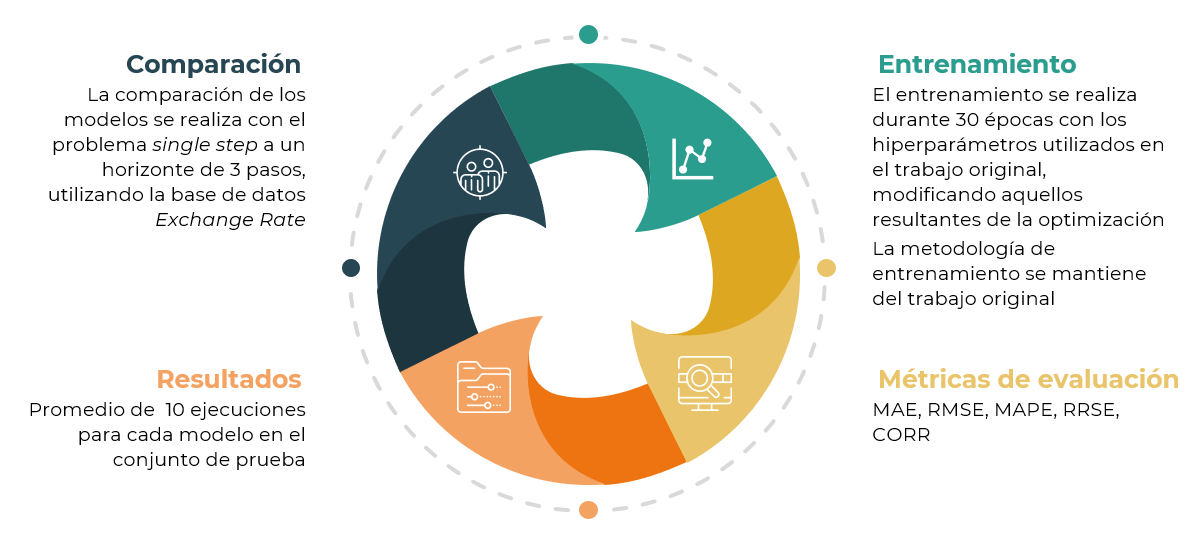

La descripción a detalle de cada sección se encuentran en la libreta `1-mtgnne`.

## 1 Preparación

### 1.1 Bibliotecas

Instalación de bibliotecas

In [1]:
#! pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113 
# inspeccionar arquitecturas
#! pip install torchinfo
# barras de progreso
#! pip install tqdm

Nota: Las siguientes librerías son para utilizar [PyTorch Geometric Temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html), que tiene cargado los [modelos](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html) ST-GNN, incluido el de [MTGNN](https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/attention/mtgnn.html#MTGNN), **pero no es necesario instalarlo** dado que todo el proyecto está realizado con PyTorch y el modelo MTGNN se tiene en el archivo `MTGNN.py` en el directorio de este notebook. Además la instalación es tardada y a veces complicada.

In [1]:
#! pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#! pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
#! pip install torch-geometric
#! pip install torch-geometric-temporal 

En el directorio del notebook se encuentran 2 archivos .py:
* `MTGNN.py` es donde se encuentra la clase `MTGNN`, que es la implementación original.
* `MTGNNe.py` es donde se encuentra la clase `MTGNNe` que es la extensión al modelo original implementando las 2 modificaciones propuestas, en la cual también se puede obtener el modelo MTGNN modificando el parámetro `arquitecture = MTGNN`

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random

# redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets.utils as tvu

# carga de los modelos (que esta en el mismo directorio que el notebook)
#from MTGNN import MTGNN
from MTGNNe import MTGNNe

# inspección de arquitectura
from torchinfo import summary

# descompresion
import gzip

# barras de progreso
from tqdm.auto import trange
from tqdm.auto import tqdm

### 1.2 Auxiliares

In [3]:
# parametros para graficas
MARKER = 'o'
MARKER_SIZE = 4

# descomprimir los archivos txt.gz -> txt
def decompress(infile, tofile):
    with open(infile, 'rb') as inf, open(tofile, 'w', encoding='utf8') as tof:
        decom_str = gzip.decompress(inf.read()).decode('utf-8')
        tof.write(decom_str)

def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))

# grafica de perdidas
def display_losses(losses, title='Model loss', plot=True, path2save=None):
    train_loss, test_loss = zip(*losses)
    # eje x (numero enteros [1,epocas])
    x = np.arange(1,len(train_loss)+1, dtype=np.int8)
    plt.figure(figsize=(8, 4))
    plt.plot(x,train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
    plt.plot(x,test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
    #plt.ylim([0,100])
    plt.xticks(x)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid()
    plt.legend()
    # guardar grafica
    if path2save is not None:
        plt.savefig(path2save)
    if not plot: 
        plt.close()
    else:
        plt.show()

# convierte una matriz de adyacencia en un tensor de aristas con sus pesos
# esto es para poder ocupar arquitecturas de torch-geometric
# NOTA: no se utiliza en el proyecto, pero como trabajo a futuro, el modelo MTGNNe puede implementar
# bloques de torch-geometric, para lo que es necesario tener la lista de aristas con sus pesos
def edges_from_adjacency(A):
    '''
    Funcion para obtener la lista de aristas y sus pesos en formato de pytorch geomtric
    A: matriz de adyacencia
    '''
    # obtener la lista de indices
    edge_index = A.nonzero().t().contiguous()
    # obtener los pesos
    n_connections = edge_index.shape[1] # numero de conexiones
    edge_weight = torch.zeros(n_connections) # inicializar tensor de pesos
    # iterar en cada conexion
    for edge in range(n_connections):
        row = edge_index[0,edge].item() # nodo origen
        column = edge_index[1,edge].item() # nodo destino
        # obtencion del peso de la matriz de adyacencia A
        weight = A[row, column].item()
        # actualizacion en el tensor de pesos
        edge_weight[edge] = weight
    
    return edge_index, edge_weight

## 2 Datos

### 2.1 Descarga de datos

Para la descarga de datos se implementó la clase `TSDatasets`, que toma como entrada la carpeta a guardar los datos `root`, el dataset que se quiere [descargar](https://github.com/laiguokun/multivariate-time-series-data):
* [Electricity consumption](https://github.com/laiguokun/multivariate-time-series-data/tree/master/electricity)
* [Traffic Ussage](https://github.com/laiguokun/multivariate-time-series-data/tree/master/traffic)
* [Solar Energy](https://github.com/laiguokun/multivariate-time-series-data/tree/master/solar-energy)
* [Exchange Rate](https://github.com/laiguokun/multivariate-time-series-data/tree/master/exchange_rate)

Dentro de la clase se descarga y se descomprimen los datos en la carpeta `root`, en caso de que ya existan los datos en la carpeta, solo se mostrará un mensaje diciendo que ya se tienen los datos si se tiene activado el despliegue de mensaje `verbose_download = True`

**Nota: En la clase solo se pueden descargar los benchmark de las series de tiempo que no tienen una estructura de grafo definida**

In [4]:
class TSDatasets():
    '''Descarga y descompresion de los datos de series de tiempo'''
    def __init__(self, root='../data', dataset='electricity', verbose_download=True):
        self.root = root # carpeta root para descargar los archivos
        # diccionario con los distintos datos de series de tiempo
        self.filenames = {
            'electricity': 'electricity.txt.gz',
            'exchange_rate': 'exchange_rate.txt.gz',
            'solar-energy': 'solar_AL.txt.gz',
            'traffic': 'traffic.txt.gz'
        }
        # diccionario con las URLs de descarga para cada conjunto de datos
        self.URLS = {
            'electricity': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/electricity/electricity.txt.gz?raw=true',
            'exchange_rate': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/exchange_rate/exchange_rate.txt.gz?raw=true',
            'solar-energy': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/solar-energy/solar_AL.txt.gz?raw=true',
            'traffic': 'https://github.com/laiguokun/multivariate-time-series-data/blob/master/traffic/traffic.txt.gz?raw=true'
        }
        self.filename = self.filenames[dataset] # nombre del archivo .txt.gz
        # path para guardar el archivo txt.gz del conjunto deseado
        self.data_dir = os.path.join(root, self.filename)
        self.URL = self.URLS[dataset] # URL de descarga del conjunto deseado
        # path del archivo txt para descomprimir la informacion
        self.file_txt = os.path.join(root, dataset + '.txt')
        # crear carpeta root (en caso de no existir)
        self.create_root()
        # descargar y descomprimir los datos
        self.download(verbose_download)

    def _check_integrity_download(self):
        return os.path.isfile(self.data_dir)

    def _check_integrity_extract(self):
        return os.path.isfile(self.file_txt)

    def create_root(self):
        if not os.path.isdir(self.root):
            os.makedirs(self.root)

    def _extract(self,root, filename):
        # crear archivo txt de escritura si no existe
        if not os.path.isfile(self.file_txt):
            f = open(self.file_txt, "x")

        # extraer
        decompress(self.data_dir, self.file_txt)

    def download(self, verbose):
        # revisar si los archivos estan descargados y descomprimidos
        if self._check_integrity_download():
            if verbose: print('Files already downloaded')
            if self._check_integrity_extract():
                if verbose: print('Files already decompressed')
                return

        # descarga
        tvu.download_url(
            url=self.URL,
            root=self.root,
            filename=self.filename
        )
        # extraccion
        self._extract(self.root, self.filename)

### 2.2 Cargador de datos

Modificación al `DataLoaderS` original para que sea más transparente en la lógica, creando así la clase `DataLoaderS2`. Para mayor información referir al notebook `1-mtgnne-complete`.

In [5]:
class DataLoaderS2(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train_ratio, valid_ratio, device, horizon, window, normalize=2):
        self.window = window
        self.horizon = horizon
        fin = open(file_name) # abrir el archivo
        self.rawdat = np.loadtxt(fin, delimiter=',') # separar txt por comas
        self.dat = np.zeros(self.rawdat.shape) # inicializar del tamanio de rawdata (filas, columnas)
        self.rows, self.attrs = self.dat.shape # rows -> tuplas, attrs -> variables -> num de nodos
        self.num_nodes = self.attrs # los nodos son las variables
        self.normalize = 2
        self.scale = np.ones(self.attrs) # de tamanio del numero de nodos (atributos)
        self._normalized(normalize)
        # separar el conjunto en diferentes conjuntos: entrenamiento, validacion, y prueba
        self._split(int(train_ratio * self.rows), int((train_ratio + valid_ratio) * self.rows), self.rows)

        self.scale = torch.from_numpy(self.scale).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.attrs)

        self.scale = self.scale.to(device)
        self.scale = Variable(self.scale)

        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))

        self.device = device

    def _normalized(self, normalize):
        # normalized by the maximum value of entire matrix.

        if (normalize == 0):
            self.dat = self.rawdat

        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat)

        # normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.attrs):
                self.scale[i] = np.max(np.abs(self.rawdat[:, i]))
                self.dat[:, i] = self.rawdat[:, i] / np.max(np.abs(self.rawdat[:, i]))

    def _split(self, train_size, valid_size, test_size):
        # generar los rangos para cada conjunto 
        train_range = range(self.window + self.horizon - 1, train_size)
        valid_range = range(train_size, valid_size)
        test_range = range(valid_size, test_size)
        # generar los tensores X, Y para cada conjunto
        self.train = self._batchify(train_range, self.horizon)
        self.valid = self._batchify(valid_range, self.horizon)
        self.test = self._batchify(test_range, self.horizon)

    def _batchify(self, set_range, horizon):
        # set_range -> es el rango del conjunto (entrenamiento, prueba o valid)
        # generar tensores X, Y
        n_set = len(set_range) # tamanio del rango del conjunto
        # inicializar tensores
        # [R,W,N]
        # R -> filas (tuplas), W -> ventana de tiempo, N -> nodos
        X = torch.zeros((n_set, self.window, self.attrs)) 
        # [R,N]
        Y = torch.zeros((n_set, self.attrs))
        # llenar los tensores al recorrer la ventana de tiempo y horizonte
        for i in range(n_set):
            end = set_range[i] - self.horizon + 1 # idx de inicio de la ventana de tiempo
            start = end - self.window # idx de fin de la ventana de tiempo
            # colocar valores de la ventana en X
            X[i, :, :] = torch.from_numpy(self.dat[start:end, :])
            # colocar valor de ventana + horizonte como Y
            Y[i, :] = torch.from_numpy(self.dat[set_range[i], :])
        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]
            Y = targets[excerpt]
            X = X.to(self.device)
            Y = Y.to(self.device)
            yield Variable(X), Variable(Y)
            start_idx += batch_size

## 3 Modelo

Instancia de las distintas arquitecturas:
* **MTGNN** es la arquitectura original propuesta en el artículo.
* **MTGAN** es la arquitectura que implementa mecanismos de atención al agregar la información de un nodo con sus vecinos.
* **MTGNNAH** es la arquitectura **MTGNN** con mecanismos de atención al propagar la información en el número de capas de la GCN.
* **MTGANAH** es la arquitectura **MTGAN** con mecanismos de atención al propagar la información en el número de capas de la GCN.

Dentro de la clase `MTGNNe` del archivo `MTGNNe.py` se puede obtener cada arquitectura al variar el parámetro `arquitecture`. Los parámetros del modelo `MTGNN` se mantienen en la clase `MTGNNe` con 3 parámetros adicionales que son `arquitecture`, `n_heads`, `concat`. A continuación se desriben los paraémtros de `MTGNNe`:

* `gcn_true` (bool): Whether to add graph convolution layer.
* `build_adj` (bool): Whether to construct adaptive adjacency matrix.
* `gcn_depth` (int): Graph convolution depth.
* `num_nodes` (int): Number of nodes in the graph.
* `kernel_set` (list of int): List of kernel sizes.
* `kernel_size` (int): Size of kernel for convolution, to calculate receptive field size.
* `dropout` (float): Droupout rate.
* `subgraph_size` (int): Size of subgraph.
* `node_dim` (int): Dimension of nodes.
* `dilation_exponential` (int): Dilation exponential.
* `conv_channels` (int): Convolution channels.
* `residual_channels` (int): Residual channels.
* `skip_channels` (int): Skip channels.
* `end_channels` (int): End channels.
* `seq_length` (int): Length of input sequence (window).
* `in_dim` (int): Input dimension.
* `out_dim` (int): Output dimension.
* `layers` (int): Number of layers.
* `propbeta` (float): Prop beta, ratio of retaining the root nodes's original states in mix-hop propagation, a value between 0 and 1.
* `tanhalpha` (float): Tanh alpha for generating adjacency matrix, alpha controls the saturation rate.
* `layer_norm_affline` (bool): Whether to do elementwise affine in Layer Normalization.
* `xd` (int, optional): Static feature dimension, default None.
* `arquitecture` (str): Type of arquitecture to use ('MTGNN'->original, 'MTGAN'->attention in adj_matrix, 'MTGNNAH'->MTGNN with attention in hops,'MTGANAH'->MTGAN with attention in hops)
* `n_heads` (int): Number of attention heads, in case to use MTGAN or MTGANAH
* `concat` (bool): Whether the multi-head results should be concatenated or averaged, in case to use MTGAN or MTGANAH

El número de nodos se obtiene directamente del `DataLoaderS2`, que es el número de variables en la base de datos

## 4 Ciclo de entrenamiento

El ciclo de entrenamiento se mantuvo con la idea del [original](https://github.com/nnzhan/MTGNN/blob/master/train_single_step.py), pero con la estructura del ciclo de entrenamiento que se ha manejado a lo largo del curso.

In [6]:
def train_epoch(data_loader, X, Y, model, criterion, optim, batch_size, 
                step_size, num_nodes, num_split, clip, verbose=True):
    model.train() # modelo en modo de entrenamiento
    # inicializar metricas
    total_loss = 0
    n_samples = 0
    iter = 0 # el numero de iteraciones esta dado por size_set/batch_size
    # X -> [S, W, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    # Y -> [S, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    for X, Y in data_loader.get_batches(X, Y, batch_size, True):
        # X -> [B, W, N]
        # Y -> [B, N]
        model.zero_grad() # vaciar los gradientes
        X = torch.unsqueeze(X,dim=1) # [B, 1, W, N]
        X = X.transpose(2,3) # [B, 1, N, W]
        if iter % step_size == 0:
            perm = np.random.permutation(range(num_nodes))
        num_sub = int(num_nodes / num_split)

        for j in range(num_split):
            if j != num_split - 1:
                id = perm[j * num_sub:(j + 1) * num_sub]
            else:
                id = perm[j * num_sub:]
            
            id = torch.tensor(id, dtype=torch.long).to(device)
            tx = X[:, :, id, :]
            ty = Y[:, id]
            output = model(tx,id)
            output = torch.squeeze(output)
            scale = data_loader.scale.expand(output.size(0), data_loader.attrs)
            scale = scale[:,id]
            loss = criterion(output * scale, ty * scale)
            loss.backward()
            total_loss += loss.item()
            n_samples += (output.size(0) * data_loader.attrs)
            # compute gradient norm
            grad_norm = 0
            if clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            grad_norm = optim.step()

            if iter%100==0 and verbose:
                print('iter:{:3d} | loss: {:.3f}'.format(iter,loss.item()/(output.size(0) * data_loader.attrs)))
            iter += 1
    return total_loss / n_samples

def evaluate(data_loader, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval() # pasar el modelo en modo de evaluacion
    # inicializar variables
    total_loss = 0
    total_loss_l1 = 0
    n_samples = 0
    predict = None
    test = None
    # X -> [S, W, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    # Y -> [S, N] (S->tamanio del conjunto, W->ventana de tiempo, N->num de nodos)
    for X, Y in data_loader.get_batches(X, Y, batch_size, False):
        # X -> [B, W, N]
        X = torch.unsqueeze(X,dim=1) # [B, 1, W, N]
        X = X.transpose(2,3) # [B, 1, N, W]
        with torch.no_grad():
            output = model(X) # [B, 1, N, 1] 
        output = torch.squeeze(output) # [B, N] (la salida es el valor de los N nodos)
        if len(output.shape)==1:
            output = output.unsqueeze(dim=0)
        # ir acumulando los lotes
        if predict is None:
            # condicion de arranque
            predict = output
            test = Y
        else:
            # ir concatenando los valores
            predict = torch.cat((predict, output))
            test = torch.cat((test, Y))

        scale = data_loader.scale.expand(output.size(0), data_loader.attrs)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data_loader.attrs)

    # metricas
    ## rse, rae
    rse = math.sqrt(total_loss / n_samples) / data_loader.rse
    rae = (total_loss_l1 / n_samples) / data_loader.rae
    ## correlation
    predict = predict.data.cpu().numpy()
    Ytest = test.data.cpu().numpy()
    sigma_p = (predict).std(axis=0)
    sigma_g = (Ytest).std(axis=0)
    mean_p = predict.mean(axis=0)
    mean_g = Ytest.mean(axis=0)
    index = (sigma_g != 0)
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis=0) / (sigma_p * sigma_g)
    correlation = (correlation[index]).mean()
    
    return rse, rae, correlation


def train(model, data_loader, num_nodes, batch_size=32, epochs=30, lr=1-3, 
          opt='Adam', weight_decay = 0.00001, L1Loss = True, step_size=100, 
          num_split=1, clip=5, progress=False, verbose=True, verbose_train=False,
          save_best_model=None):

    # optimizadores
    # optimizador seleccionado
    if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(),lr=lr, weight_decay=weight_decay)
    elif opt == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters(),lr=lr, weight_decay=weight_decay)
    else:
        raise RuntimeError("Invalid optim method: " + opt)
    
    # definir criteria
    criterion = nn.L1Loss(reduction='sum').to(device) if L1Loss else nn.MSELoss(reduction='sum').to(device)
    # metodos de evalaucion
    evaluateL2 = nn.MSELoss(reduction='sum').to(device)
    evaluateL1 = nn.L1Loss(reduction='sum').to(device)

    # definir si se quiere o no imprimir el progreso
    range_progress = trange(1, epochs + 1)  if progress else range(1, epochs + 1)

    # historiales
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range_progress:
        epoch_start_time = time.time() # tomar tiempo de inicio
        # entrenamiento de la epoca
        X = data_loader.train[0] # [rows, window, num_nodes]
        Y = data_loader.train[1] # [rows, num_nodes]
        train_loss = train_epoch(data_loader, X, Y, model, criterion, optimizer, batch_size, step_size, num_nodes, 
                                 num_split, clip, verbose_train)
        # evaluacion de la epoca
        X_valid = data_loader.valid[0]
        Y_valid = data_loader.valid[1]
        val_loss, val_rae, val_corr = evaluate(data_loader, X_valid, Y_valid, model, evaluateL2, evaluateL1, batch_size)
        # actualizacion de historiales
        loss_hist.append([train_loss, val_loss])
        # impresion de resultados
        if verbose:
            print(
                    '| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid loss (rse) {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(
                        epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr), flush=True)

        # guardar el mejor modelo
        if save_best_model is not None:
            best_val = 1e8
            if val_loss < best_val:
                with open(save_best_model, 'wb') as f:
                    torch.save(model, f)
                best_val = val_loss
            if epoch % 5 == 0:
                X_valid = data_loader.valid[0]
                Y_valid = data_loader.valid[1]
                test_acc, test_rae, test_corr = evaluate(data_loader, X_valid, Y_valid, model, evaluateL2, evaluateL1, batch_size)
                print("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr), flush=True)

    return loss_hist

### 4.1 Evaluación del mejor modelo

La función `evaluate_model` toma un modelo que está guardado en un directorio y evalúa su rendimiento con el conjunto de validación y prueba.

In [7]:
def evaluate_model(data_loader, model_path, batch_size, verbose=True):
    # abrir el modelo
    # TODO: que tambien admita una instancia de un modelo
    with open(model_path, 'rb') as f:
        model = torch.load(f)

    # metodos de evalaucion
    evaluateL2 = nn.MSELoss(reduction='sum').to(device)
    evaluateL1 = nn.L1Loss(reduction='sum').to(device)

    # conjunto de validacion 
    vtest_acc, vtest_rae, vtest_corr = evaluate(data_loader, data_loader.valid[0], data_loader.valid[1], 
                                                model, evaluateL2, evaluateL1, batch_size)
    # conjunto de prueba
    test_acc, test_rae, test_corr = evaluate(data_loader, data_loader.test[0], data_loader.test[1], 
                                             model, evaluateL2, evaluateL1, batch_size)
    if verbose:
        print("Final test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

    return vtest_acc, vtest_rae, vtest_corr, test_acc, test_rae, test_corr

## 5 Definición de los experimentos

In [8]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
# CARGADOR DE DATOS
root='../data' # directorio para guardar los datos
dataset = 'exchange_rate' # dataset a analizar (electricity, exchange_rate, solar-energy, traffic)
train_ratio = 0.6 # proporcion del conjunto de entrenamiento
valid_ratio = 0.2 # proporcion del conjunto de evaluacion
horizon = 3 # numero de pasos a realizar la prediccion
normalize = 2 # tipo de normalizacion en el DataLoaderS2
batch_size = 4 # tamanio de lote

# ENTRENAMIENTO
epochs = 5 # numero de epocas de entrenamiento
lr = 1e-4 # learning rate
opt = 'Adam' # optimizador (SGD, RMSProp, Adam, Adagrad, Adadelta)
weight_decay = 1e-5 # factor de penalizacion
L1Loss = True # tipo de perdida (L1Loss o MSELoss (False))
step_size = 100 # impresion de resultados en el paso step_size
num_split = 1
clip = 5
save_path_model = './model-exchange-3.pt' # ruta para guardar el modelo final

# MODELO
## GENERAL
gcn_true = True # agregar capa de graph convolution (MixProp)
build_adj = True # construir la matriz de adyacencia A (Graph Learning Layer)
dropout = 0.3
kernel_size = 7 # (auxiliar para el calculo del campo receptivo)
window = 24*7 # ventana de tiempo hacia atras (lags)
arquitecture = 'MTGNN' # MTGNN, MTGAN, MTGNNAH, MTGANAH
## connections
conv_channels = 16 # numero de canales en el gcn
residual_channels = 16 # numero de canales en las residuales (entrada a cada capa mtgnn)
skip_channels = 32 # numero de canales de las conexiones skip
## MixProp
gcn_depth = 2 # profundidad de la gcn (no debe ser grande -> over-smoothing)
propbeta = 0.05 # controla la proporcion de retencion del estado original
### GraphAttentionLayer
n_heads = 16 # numero de cabezas
concat = True # si se concatena en la salida de las cabezas o se toma el promedio (False)
## DilatedInception
kernel_set = [2,3,6,7] # lista de kernels que se ocupan en la capa Dilated inception
dilation_exponential = 2 # dilatacion exponencial (controla el tamanio del campo receptivo)
## GraphConstructor
# num_nodes -> el numero de nodos se calcula en el DataLoaderS2 (# de variables)
subgraph_size = 8 # tamanio del subgrafo -> topk(subgraph_size)
node_dim = 40 # dimension del embedding de los nodos
tanhalpha = 3 # tasa de saturacion de tanh
xd = None
## MTGNNLayer
layers = 5 # numero de capas mtgnn (TC & GC)
layer_norm_affline = False # hacer afin a los elementos en la normalizacion de capas
## MTGNNe
in_dim = 1 # canales de entrada para la convolucion inicial
end_channels = 64 # numero de canales en el modulo de salida
out_dim = 1 # canales de salida en la convolucion final

# VERBOSE
progress_train = True # observar la barra de progreso del entrenamiento
verbose_train = True # imprimir resultados de entrenamiento
verbose_train_epoch = False # mostrar la perdida de entrenamiento y validacion por epoca
verbose_summary = True # imprimir el numero de parametros del modelo
verbose_evaluation = True # imprimir las metricas en el conjunto de prueba
verbose_download = True # imprimir mensajes en la descarga de los datos
plot_losses = True # graficar las perdidas al terminar el entrenamiento
save_path_plot = None # save plot of train and valida losses

### 5.1 Ejecución del pipeline completo

La función `run_pipeline` realiza la ejecución de todo el pipeline:
1. Descarga y descompresión del conjunto de datos deseado
2. Carga del DataLoader
3. Instancia del modelo según el parámetro `arquitecture`
4. Mover el modelo al GPU o CPU
5. Entrenamiento del modelo instanciado
6. Evaluación del modelo en el conjunto de prueba

In [10]:
def run_pipeline(root='../data', dataset='exchange_rate', train_ratio=0.6, valid_ratio=0.2, 
                 horizon=3, window=24*7, normalize=2, batch_size=32, epochs=5,
                 lr=1e-4, opt='Adam', weight_decay=1e-5, L1Loss=True, step_size=100,
                 num_split=1, clip=5, save_path_model=None, 
                 gcn_true=True, build_adj=True, gcn_depth=2, kernel_set=[2,3,6,7],
                 kernel_size=7, dropout=0.3, subgraph_size=20, node_dim=40, 
                 dilation_exponential=2, conv_channels=16, residual_channels=16,
                 skip_channels=32, end_channels=64, in_dim=1, out_dim=1, layers=5,
                 propbeta=0.05, tanhalpha=3, layer_norm_affline=False, 
                 arquitecture='MTGNN', n_heads=1, concat=True,xd=None,
                 progress_train=True, verbose_train=True, verbose_train_epoch=False,
                 verbose_summary=False, verbose_evaluation=True,
                 verbose_download=False, plot_losses=True, save_path_plot=None):
  
    # DATOS
    ## descarga y descompresion del conjunto de datos deseado
    ds = TSDatasets(root, dataset, verbose_download)
    ds_data_dir = ds.file_txt # path al conjunto de datos
    # obtener dispositivo
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ## carga del dataloader
    data = DataLoaderS2(ds_data_dir, train_ratio, valid_ratio, device, 
                      horizon, window, normalize)

    num_nodes = data.num_nodes

    # MODELO
    model = MTGNNe(gcn_true, build_adj, gcn_depth, num_nodes, kernel_set, kernel_size,
              dropout, subgraph_size, node_dim, dilation_exponential,
              conv_channels, residual_channels, skip_channels, end_channels,
              window, in_dim, out_dim, layers, propbeta, tanhalpha,
              layer_norm_affline, arquitecture, n_heads, concat, xd)

    if verbose_summary:
        #summary(model, (batch_size, 1, num_nodes, window), device='cpu')
        nParams = sum([p.nelement() for p in model.parameters()])
        print('Number of model parameters is', nParams, flush=True)

    # mover modelo
    model = model.to(device)

    # ENTRENAMIENTO
    loss_h = train(model, data, num_nodes, batch_size, epochs, lr, opt, weight_decay,
                 L1Loss, step_size, num_split, clip, progress_train, verbose_train, 
                 verbose_train_epoch, save_path_model)

    # grafica de perdidas
    if plot_losses or save_path_plot is not None:
        print('\n')
        title = f'{arquitecture} - Loss'
        display_losses(loss_h, title, plot_losses, save_path_plot)

    # EVALUACION
    #if verbose_evaluation: print('\n')
    vtest_acc, vtest_rae, vtest_corr, test_acc, test_rae, test_corr = evaluate_model(data,
                                                                                   save_path_model,
                                                                                   batch_size,
                                                                                   verbose_evaluation)
    return vtest_acc, vtest_rae, vtest_corr, test_acc, test_rae, test_corr

### 5.2 Ejecución de experimentos

La función `run_experiments` realiza `n_iterations` ejecuciones del pipeline, tomando como entrada los parámetros definidos en pasos anteriores. En cada ejecución se guardan los resultados de las métricas y tiempo de ejecución en listas, para que al término de las `n_iterations` iteraciones se obtenga el promedio y desviación estándar de cada métrica y tiempo de ejecución del experimento.

In [11]:
def run_experiments(n_iterations=10, epochs=2, dir_results='./', progress_train=True, verbose_train=False, 
                    verbose_train_epoch=False, verbose_evaluation=True, verbose_download=False, 
                    plot_losses=True, save_models=True, save_plots=True):
    # inicializacion de listas para guardar los resultados por experimento
    vacc = []
    vrae = []
    vcorr = []
    acc = []
    rae = []
    corr = []
    time_per_it = [] # lista para guardar los tiempos de ejecucion
    
    for i in trange(n_iterations):
        # actualizar parametros para guardar los modelos y graficas
        save_path_model_it = os.path.join(dir_results, f'{arquitecture}-{dataset}-{i}.pt') if save_models else None
        save_path_plot_it = os.path.join(dir_results, f'{arquitecture}-{dataset}-{i}.png') if save_plots else None
        verbose_summary = True if i==0 else None # imprimir numero de parametros solo en la primera ejecucion
        
        start = time.time()
        val_acc, val_rae, val_corr, test_acc, test_rae, test_corr = run_pipeline(root,dataset, train_ratio, valid_ratio, 
                     horizon, window, normalize, batch_size, epochs,
                     lr, opt, weight_decay, L1Loss, step_size,
                     num_split, clip, save_path_model_it, 
                     gcn_true, build_adj, gcn_depth, kernel_set,
                     kernel_size, dropout, subgraph_size, node_dim, 
                     dilation_exponential, conv_channels, residual_channels,
                     skip_channels, end_channels, in_dim, out_dim, layers,
                     propbeta, tanhalpha, layer_norm_affline,
                     arquitecture, n_heads, concat, xd,
                     progress_train, verbose_train, verbose_train_epoch,
                     verbose_summary, verbose_evaluation, verbose_download,plot_losses, save_path_plot_it)
        elapsed_time = (time.time() - start)/60 # tiempo de ejecucion en minutos
        # agregar resultados a las listas
        vacc.append(val_acc)
        vrae.append(val_rae)
        vcorr.append(val_corr)
        acc.append(test_acc)
        rae.append(test_rae)
        corr.append(test_corr)
        time_per_it.append(elapsed_time)

    # impresion de resultados
    print('\n')
    print(f'*** Results: Average from {n_iterations} runs ***')
    print('\n')
    print("valid\trse\trae\tcorr")
    print("mean\t{:5.4f}\t{:5.4f}\t{:5.4f}".format(np.mean(vacc), np.mean(vrae), np.mean(vcorr)))
    print("std\t{:5.4f}\t{:5.4f}\t{:5.4f}".format(np.std(vacc), np.std(vrae), np.std(vcorr)))
    print('\n')
    print("test\trse\trae\tcorr")
    print("mean\t{:5.4f}\t{:5.4f}\t{:5.4f}".format(np.mean(acc), np.mean(rae), np.mean(corr)))
    print("std\t{:5.4f}\t{:5.4f}\t{:5.4f}".format(np.std(acc), np.std(rae), np.std(corr)))
    #print('\n')
    #print(f'Execution time [min], mean: {np.mean(time_per_it)}, std: {np.std(time_per_it)}')
    print("Execution time [min], mean: {:5.4f}, std: {:5.4f}".format(np.mean(time_per_it), np.std(time_per_it)))

## 6 Ejecución de experimentos

A continuación se realizan los experimentos de todas las arquitecturas (la original y las propuestas): **MTGNN, MTGAN, MTGNNAH, MTGANAH**. Para estos experimentos se mantienes los hiperparámetros del [trabajo original](https://github.com/nnzhan/MTGNN).

Para cada experimento, dentro del directorio `../experiments/{datasets}` se genera una carpeta con el nombre de la arquitectura que se está probando, dentro de la misma se guarda tanto el mejor modelo como las gráficas de las pérdidas durante el entrenamiento para cada ejecución.

### 6.1 Experimentos sobre las arquitecturas

In [12]:
models_arq = ['MTGNN', 'MTGAN', 'MTGNNAH', 'MTGANAH'] # arquitecturas del modelo
n_iterations = 10 # numero de iteraciones
epochs = 30 # numero de epocas por ejecucion

# ejecutar experimentos para cada arquitectura
for i in trange(len(models_arq)):
    # actualizar arquitectura que se va a probar
    arquitecture = models_arq[i]
    print(f'************************* Experiments of {arquitecture} *************************')
    # crear directorio para guardar los resultados
    dir_save_experiments = f'../experiments/{dataset}/{arquitecture}'
    if not os.path.exists(dir_save_experiments):
        os.makedirs(dir_save_experiments)
    
    # ejecutar los experimentos
    run_experiments(n_iterations, epochs, dir_save_experiments, progress_train=True, verbose_train=False, 
                    verbose_train_epoch=False, verbose_evaluation=True, verbose_download=False, 
                    plot_losses=False, save_models=True, save_plots=True)

../experiments/exchange_rate/MTGNN


  0%|          | 0/4 [00:00<?, ?it/s]

************************* Experiments of MTGNN *************************


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model parameters is 337345


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0709 | test rae 0.0707 | test corr 0.9754
test rse 0.0475 | test rae 0.0454 | test corr 0.9824
test rse 0.0467 | test rae 0.0402 | test corr 0.9846
test rse 0.0332 | test rae 0.0270 | test corr 0.9875
test rse 0.0312 | test rae 0.0256 | test corr 0.9888
test rse 0.0294 | test rae 0.0239 | test corr 0.9898


Final test rse 0.0241 | test rae 0.0200 | test corr 0.9796


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0938 | test rae 0.0867 | test corr 0.9635
test rse 0.0437 | test rae 0.0353 | test corr 0.9768
test rse 0.0389 | test rae 0.0307 | test corr 0.9816
test rse 0.0375 | test rae 0.0296 | test corr 0.9846
test rse 0.0371 | test rae 0.0339 | test corr 0.9874
test rse 0.0340 | test rae 0.0310 | test corr 0.9892


Final test rse 0.0260 | test rae 0.0234 | test corr 0.9793


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0759 | test rae 0.0632 | test corr 0.9598
test rse 0.0415 | test rae 0.0335 | test corr 0.9769
test rse 0.0426 | test rae 0.0391 | test corr 0.9810
test rse 0.0340 | test rae 0.0290 | test corr 0.9846
test rse 0.0313 | test rae 0.0253 | test corr 0.9864
test rse 0.0303 | test rae 0.0255 | test corr 0.9879


Final test rse 0.0209 | test rae 0.0172 | test corr 0.9785


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0615 | test rae 0.0494 | test corr 0.9655
test rse 0.0664 | test rae 0.0598 | test corr 0.9788
test rse 0.0413 | test rae 0.0382 | test corr 0.9847
test rse 0.0342 | test rae 0.0297 | test corr 0.9861
test rse 0.0343 | test rae 0.0283 | test corr 0.9876
test rse 0.0336 | test rae 0.0295 | test corr 0.9875


Final test rse 0.0230 | test rae 0.0196 | test corr 0.9787


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0544 | test rae 0.0492 | test corr 0.9697
test rse 0.0456 | test rae 0.0411 | test corr 0.9795
test rse 0.0363 | test rae 0.0293 | test corr 0.9836
test rse 0.0390 | test rae 0.0336 | test corr 0.9873
test rse 0.0320 | test rae 0.0285 | test corr 0.9891
test rse 0.0429 | test rae 0.0423 | test corr 0.9903


Final test rse 0.0377 | test rae 0.0377 | test corr 0.9803


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0947 | test rae 0.0885 | test corr 0.9651
test rse 0.0425 | test rae 0.0353 | test corr 0.9769
test rse 0.0393 | test rae 0.0355 | test corr 0.9834
test rse 0.0344 | test rae 0.0278 | test corr 0.9857
test rse 0.0335 | test rae 0.0281 | test corr 0.9876
test rse 0.0305 | test rae 0.0264 | test corr 0.9889


Final test rse 0.0224 | test rae 0.0191 | test corr 0.9788


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0465 | test rae 0.0381 | test corr 0.9742
test rse 0.0393 | test rae 0.0347 | test corr 0.9828
test rse 0.0326 | test rae 0.0271 | test corr 0.9861
test rse 0.0357 | test rae 0.0328 | test corr 0.9884
test rse 0.0293 | test rae 0.0247 | test corr 0.9898
test rse 0.0287 | test rae 0.0238 | test corr 0.9906


Final test rse 0.0221 | test rae 0.0181 | test corr 0.9804


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0514 | test rae 0.0436 | test corr 0.9676
test rse 0.0421 | test rae 0.0353 | test corr 0.9785
test rse 0.0820 | test rae 0.0827 | test corr 0.9834
test rse 0.0364 | test rae 0.0325 | test corr 0.9859
test rse 0.0310 | test rae 0.0263 | test corr 0.9882
test rse 0.0536 | test rae 0.0512 | test corr 0.9887


Final test rse 0.0457 | test rae 0.0467 | test corr 0.9797


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1096 | test rae 0.1049 | test corr 0.9658
test rse 0.0497 | test rae 0.0405 | test corr 0.9781
test rse 0.0561 | test rae 0.0562 | test corr 0.9835
test rse 0.0324 | test rae 0.0265 | test corr 0.9875
test rse 0.0357 | test rae 0.0328 | test corr 0.9890
test rse 0.0347 | test rae 0.0321 | test corr 0.9898


Final test rse 0.0274 | test rae 0.0255 | test corr 0.9791


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0493 | test rae 0.0398 | test corr 0.9685
test rse 0.0455 | test rae 0.0378 | test corr 0.9788
test rse 0.0371 | test rae 0.0324 | test corr 0.9833
test rse 0.0468 | test rae 0.0407 | test corr 0.9845
test rse 0.0320 | test rae 0.0263 | test corr 0.9876
test rse 0.0330 | test rae 0.0271 | test corr 0.9889


Final test rse 0.0261 | test rae 0.0232 | test corr 0.9794


*** Results: Average from 10 runs ***


valid	rse	rae	corr
mean	0.0351	0.0313	0.9892
std	0.0073	0.0084	0.0009


test	rse	rae	corr
mean	0.0275	0.0250	0.9794
std	0.0075	0.0091	0.0006
Execution time [min], mean: 33.7434, std: 0.1509
************************* Experiments of MTGAN *************************


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model parameters is 340095


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0929 | test rae 0.0731 | test corr 0.8990
test rse 0.0840 | test rae 0.0803 | test corr 0.9427
test rse 0.0680 | test rae 0.0538 | test corr 0.9537
test rse 0.0596 | test rae 0.0513 | test corr 0.9595
test rse 0.0658 | test rae 0.0609 | test corr 0.9625
test rse 0.0542 | test rae 0.0458 | test corr 0.9642


Final test rse 0.0328 | test rae 0.0283 | test corr 0.9624


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0904 | test rae 0.0675 | test corr 0.9173
test rse 0.0685 | test rae 0.0542 | test corr 0.9537
test rse 0.0719 | test rae 0.0591 | test corr 0.9607
test rse 0.0696 | test rae 0.0602 | test corr 0.9674
test rse 0.0907 | test rae 0.0873 | test corr 0.9694
test rse 0.0488 | test rae 0.0388 | test corr 0.9724


Final test rse 0.0349 | test rae 0.0302 | test corr 0.9679


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1009 | test rae 0.0809 | test corr 0.8824
test rse 0.0852 | test rae 0.0652 | test corr 0.9388
test rse 0.0727 | test rae 0.0578 | test corr 0.9575
test rse 0.0618 | test rae 0.0564 | test corr 0.9645
test rse 0.0559 | test rae 0.0435 | test corr 0.9688
test rse 0.0661 | test rae 0.0640 | test corr 0.9710


Final test rse 0.0497 | test rae 0.0487 | test corr 0.9666


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1303 | test rae 0.1194 | test corr 0.9349
test rse 0.0715 | test rae 0.0589 | test corr 0.9592
test rse 0.0625 | test rae 0.0528 | test corr 0.9677
test rse 0.0527 | test rae 0.0468 | test corr 0.9723
test rse 0.0461 | test rae 0.0387 | test corr 0.9747
test rse 0.0576 | test rae 0.0504 | test corr 0.9750


Final test rse 0.0497 | test rae 0.0487 | test corr 0.9685


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1029 | test rae 0.0968 | test corr 0.8866
test rse 0.0743 | test rae 0.0665 | test corr 0.9462
test rse 0.0632 | test rae 0.0479 | test corr 0.9539
test rse 0.0678 | test rae 0.0588 | test corr 0.9616
test rse 0.0724 | test rae 0.0593 | test corr 0.9569
test rse 0.0774 | test rae 0.0765 | test corr 0.9657


Final test rse 0.0596 | test rae 0.0596 | test corr 0.9636


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0946 | test rae 0.0827 | test corr 0.9045
test rse 0.1507 | test rae 0.1456 | test corr 0.9453
test rse 0.0884 | test rae 0.0744 | test corr 0.9565
test rse 0.0617 | test rae 0.0479 | test corr 0.9628
test rse 0.0750 | test rae 0.0736 | test corr 0.9669
test rse 0.0564 | test rae 0.0512 | test corr 0.9694


Final test rse 0.0379 | test rae 0.0347 | test corr 0.9661


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1006 | test rae 0.0767 | test corr 0.8852
test rse 0.0778 | test rae 0.0644 | test corr 0.9290
test rse 0.1537 | test rae 0.1537 | test corr 0.9470
test rse 0.0660 | test rae 0.0577 | test corr 0.9532
test rse 0.0610 | test rae 0.0520 | test corr 0.9574
test rse 0.0780 | test rae 0.0652 | test corr 0.9595


Final test rse 0.0666 | test rae 0.0650 | test corr 0.9603


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0780 | test rae 0.0589 | test corr 0.9428
test rse 0.0619 | test rae 0.0534 | test corr 0.9570
test rse 0.0548 | test rae 0.0426 | test corr 0.9654
test rse 0.0567 | test rae 0.0511 | test corr 0.9686
test rse 0.0539 | test rae 0.0425 | test corr 0.9647
test rse 0.0509 | test rae 0.0406 | test corr 0.9717


Final test rse 0.0379 | test rae 0.0334 | test corr 0.9647


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1174 | test rae 0.1145 | test corr 0.9067
test rse 0.1041 | test rae 0.1063 | test corr 0.9488
test rse 0.0719 | test rae 0.0661 | test corr 0.9589
test rse 0.0554 | test rae 0.0461 | test corr 0.9632
test rse 0.0740 | test rae 0.0629 | test corr 0.9657
test rse 0.0486 | test rae 0.0405 | test corr 0.9710


Final test rse 0.0340 | test rae 0.0299 | test corr 0.9656


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0998 | test rae 0.0747 | test corr 0.9089
test rse 0.0961 | test rae 0.0954 | test corr 0.9382
test rse 0.0622 | test rae 0.0488 | test corr 0.9536
test rse 0.0598 | test rae 0.0510 | test corr 0.9578
test rse 0.0593 | test rae 0.0523 | test corr 0.9619
test rse 0.0748 | test rae 0.0727 | test corr 0.9654


Final test rse 0.0589 | test rae 0.0578 | test corr 0.9621


*** Results: Average from 10 runs ***


valid	rse	rae	corr
mean	0.0613	0.0546	0.9685
std	0.0112	0.0133	0.0045


test	rse	rae	corr
mean	0.0462	0.0436	0.9648
std	0.0117	0.0132	0.0025
Execution time [min], mean: 53.8005, std: 0.5020
************************* Experiments of MTGNNAH *************************


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model parameters is 337365


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0625 | test rae 0.0503 | test corr 0.9646
test rse 0.0421 | test rae 0.0337 | test corr 0.9780
test rse 0.0359 | test rae 0.0290 | test corr 0.9839
test rse 0.0310 | test rae 0.0252 | test corr 0.9872
test rse 0.0351 | test rae 0.0285 | test corr 0.9878
test rse 0.0374 | test rae 0.0322 | test corr 0.9893


Final test rse 0.0305 | test rae 0.0292 | test corr 0.9793


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0496 | test rae 0.0392 | test corr 0.9735
test rse 0.0528 | test rae 0.0452 | test corr 0.9807
test rse 0.0392 | test rae 0.0333 | test corr 0.9850
test rse 0.0305 | test rae 0.0252 | test corr 0.9876
test rse 0.0309 | test rae 0.0265 | test corr 0.9890
test rse 0.0322 | test rae 0.0267 | test corr 0.9899


Final test rse 0.0265 | test rae 0.0243 | test corr 0.9797


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0488 | test rae 0.0389 | test corr 0.9708
test rse 0.0606 | test rae 0.0543 | test corr 0.9801
test rse 0.0333 | test rae 0.0281 | test corr 0.9845
test rse 0.0457 | test rae 0.0443 | test corr 0.9884
test rse 0.0306 | test rae 0.0241 | test corr 0.9893
test rse 0.0325 | test rae 0.0275 | test corr 0.9897


Final test rse 0.0287 | test rae 0.0261 | test corr 0.9784


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0587 | test rae 0.0486 | test corr 0.9728
test rse 0.0579 | test rae 0.0569 | test corr 0.9844
test rse 0.0381 | test rae 0.0356 | test corr 0.9879
test rse 0.0405 | test rae 0.0389 | test corr 0.9894
test rse 0.0419 | test rae 0.0374 | test corr 0.9901
test rse 0.0269 | test rae 0.0217 | test corr 0.9904


Final test rse 0.0186 | test rae 0.0147 | test corr 0.9800


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0395 | test rae 0.0334 | test corr 0.9811
test rse 0.0352 | test rae 0.0302 | test corr 0.9859
test rse 0.0549 | test rae 0.0517 | test corr 0.9886
test rse 0.0743 | test rae 0.0794 | test corr 0.9891
test rse 0.0282 | test rae 0.0222 | test corr 0.9899
test rse 0.0368 | test rae 0.0320 | test corr 0.9902


Final test rse 0.0333 | test rae 0.0316 | test corr 0.9802


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0425 | test rae 0.0362 | test corr 0.9782
test rse 0.0326 | test rae 0.0278 | test corr 0.9871
test rse 0.0500 | test rae 0.0503 | test corr 0.9888
test rse 0.0421 | test rae 0.0387 | test corr 0.9902
test rse 0.0285 | test rae 0.0231 | test corr 0.9904
test rse 0.0285 | test rae 0.0245 | test corr 0.9908


Final test rse 0.0219 | test rae 0.0186 | test corr 0.9799


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0524 | test rae 0.0404 | test corr 0.9698
test rse 0.0447 | test rae 0.0361 | test corr 0.9797
test rse 0.0358 | test rae 0.0299 | test corr 0.9841
test rse 0.0310 | test rae 0.0257 | test corr 0.9871
test rse 0.0500 | test rae 0.0465 | test corr 0.9881
test rse 0.0404 | test rae 0.0385 | test corr 0.9895


Final test rse 0.0337 | test rae 0.0331 | test corr 0.9797


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0665 | test rae 0.0646 | test corr 0.9734
test rse 0.0446 | test rae 0.0354 | test corr 0.9793
test rse 0.0479 | test rae 0.0454 | test corr 0.9836
test rse 0.0362 | test rae 0.0287 | test corr 0.9852
test rse 0.0320 | test rae 0.0275 | test corr 0.9877
test rse 0.0301 | test rae 0.0256 | test corr 0.9885


Final test rse 0.0215 | test rae 0.0180 | test corr 0.9789


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0852 | test rae 0.0878 | test corr 0.9755
test rse 0.0366 | test rae 0.0298 | test corr 0.9827
test rse 0.0447 | test rae 0.0429 | test corr 0.9856
test rse 0.0393 | test rae 0.0347 | test corr 0.9883
test rse 0.0363 | test rae 0.0320 | test corr 0.9898
test rse 0.0268 | test rae 0.0217 | test corr 0.9906


Final test rse 0.0185 | test rae 0.0145 | test corr 0.9791


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0659 | test rae 0.0508 | test corr 0.9593
test rse 0.0449 | test rae 0.0392 | test corr 0.9763
test rse 0.0676 | test rae 0.0686 | test corr 0.9817
test rse 0.0459 | test rae 0.0410 | test corr 0.9857
test rse 0.0405 | test rae 0.0344 | test corr 0.9873
test rse 0.0304 | test rae 0.0263 | test corr 0.9891


Final test rse 0.0217 | test rae 0.0184 | test corr 0.9792


*** Results: Average from 10 runs ***


valid	rse	rae	corr
mean	0.0322	0.0277	0.9898
std	0.0044	0.0049	0.0007


test	rse	rae	corr
mean	0.0255	0.0228	0.9794
std	0.0055	0.0066	0.0005
Execution time [min], mean: 34.9893, std: 0.0249
************************* Experiments of MTGANAH *************************


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model parameters is 340115


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0986 | test rae 0.0911 | test corr 0.9141
test rse 0.0744 | test rae 0.0668 | test corr 0.9484
test rse 0.0553 | test rae 0.0442 | test corr 0.9626
test rse 0.0682 | test rae 0.0652 | test corr 0.9695
test rse 0.0567 | test rae 0.0520 | test corr 0.9714
test rse 0.0470 | test rae 0.0372 | test corr 0.9736


Final test rse 0.0318 | test rae 0.0260 | test corr 0.9680


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1278 | test rae 0.1308 | test corr 0.9147
test rse 0.1013 | test rae 0.0948 | test corr 0.9615
test rse 0.0522 | test rae 0.0414 | test corr 0.9670
test rse 0.0685 | test rae 0.0596 | test corr 0.9706
test rse 0.0500 | test rae 0.0446 | test corr 0.9745
test rse 0.0453 | test rae 0.0392 | test corr 0.9764


Final test rse 0.0302 | test rae 0.0265 | test corr 0.9697


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0906 | test rae 0.0690 | test corr 0.9290
test rse 0.0678 | test rae 0.0510 | test corr 0.9525
test rse 0.0650 | test rae 0.0516 | test corr 0.9623
test rse 0.0523 | test rae 0.0418 | test corr 0.9663
test rse 0.0557 | test rae 0.0443 | test corr 0.9700
test rse 0.0654 | test rae 0.0560 | test corr 0.9716


Final test rse 0.0549 | test rae 0.0537 | test corr 0.9670


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0838 | test rae 0.0730 | test corr 0.9230
test rse 0.0778 | test rae 0.0745 | test corr 0.9528
test rse 0.0652 | test rae 0.0524 | test corr 0.9636
test rse 0.0669 | test rae 0.0562 | test corr 0.9680
test rse 0.0559 | test rae 0.0447 | test corr 0.9705
test rse 0.0683 | test rae 0.0665 | test corr 0.9724


Final test rse 0.0528 | test rae 0.0519 | test corr 0.9670


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1329 | test rae 0.1094 | test corr 0.9014
test rse 0.0743 | test rae 0.0579 | test corr 0.9387
test rse 0.0713 | test rae 0.0546 | test corr 0.9519
test rse 0.0592 | test rae 0.0464 | test corr 0.9598
test rse 0.0554 | test rae 0.0432 | test corr 0.9632
test rse 0.0523 | test rae 0.0419 | test corr 0.9661


Final test rse 0.0332 | test rae 0.0280 | test corr 0.9628


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1117 | test rae 0.1093 | test corr 0.9181
test rse 0.0760 | test rae 0.0591 | test corr 0.9514
test rse 0.0577 | test rae 0.0482 | test corr 0.9603
test rse 0.0589 | test rae 0.0516 | test corr 0.9636
test rse 0.0629 | test rae 0.0581 | test corr 0.9640
test rse 0.0694 | test rae 0.0558 | test corr 0.9667


Final test rse 0.0548 | test rae 0.0521 | test corr 0.9621


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0826 | test rae 0.0740 | test corr 0.9273
test rse 0.0641 | test rae 0.0530 | test corr 0.9530
test rse 0.0638 | test rae 0.0553 | test corr 0.9615
test rse 0.0524 | test rae 0.0424 | test corr 0.9660
test rse 0.0838 | test rae 0.0828 | test corr 0.9693
test rse 0.0688 | test rae 0.0664 | test corr 0.9710


Final test rse 0.0558 | test rae 0.0540 | test corr 0.9670


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1049 | test rae 0.1011 | test corr 0.9116
test rse 0.0833 | test rae 0.0763 | test corr 0.9525
test rse 0.0668 | test rae 0.0601 | test corr 0.9594
test rse 0.0739 | test rae 0.0588 | test corr 0.9631
test rse 0.0543 | test rae 0.0418 | test corr 0.9667
test rse 0.0896 | test rae 0.0923 | test corr 0.9728


Final test rse 0.0757 | test rae 0.0804 | test corr 0.9672


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0870 | test rae 0.0657 | test corr 0.9167
test rse 0.0902 | test rae 0.0879 | test corr 0.9512
test rse 0.1005 | test rae 0.1029 | test corr 0.9584
test rse 0.0584 | test rae 0.0517 | test corr 0.9634
test rse 0.0508 | test rae 0.0418 | test corr 0.9690
test rse 0.0510 | test rae 0.0444 | test corr 0.9708


Final test rse 0.0324 | test rae 0.0283 | test corr 0.9662


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1629 | test rae 0.1488 | test corr 0.9098
test rse 0.1256 | test rae 0.1321 | test corr 0.9533
test rse 0.0617 | test rae 0.0484 | test corr 0.9617
test rse 0.0576 | test rae 0.0447 | test corr 0.9649
test rse 0.0524 | test rae 0.0446 | test corr 0.9690
test rse 0.0858 | test rae 0.0759 | test corr 0.9710


Final test rse 0.0834 | test rae 0.0814 | test corr 0.9669


*** Results: Average from 10 runs ***


valid	rse	rae	corr
mean	0.0643	0.0576	0.9712
std	0.0146	0.0170	0.0029


test	rse	rae	corr
mean	0.0505	0.0482	0.9664
std	0.0178	0.0200	0.0022
Execution time [min], mean: 56.4672, std: 0.9931


### 6.2 Experimentos sobre MTGNNAH con los hiperparámetros optimizados

In [12]:
models_arq = 'MTGNNAH' # arquitecturas del modelo
n_iterations = 10
epochs = 30
# actualizacion de hiperparametros optimizados
window = 24*7*3
dropout = 0.1
conv_channels = 32
residual_channels = conv_channels
skip_channels = conv_channels*2
end_channels = skip_channels*2
layers = 7
propbeta = 0.2
lr = 0.00016502558278320991

# actualizar arquitectura que se va a probar
arquitecture = models_arq
print(f'************************* Experiments of {arquitecture} Opt *************************')
# crear directorio para guardar los resultados
dir_save_experiments = f'../experiments/{dataset}/{arquitecture}-opt'
if not os.path.exists(dir_save_experiments):
    os.makedirs(dir_save_experiments)

# ejecutar los experimentos
run_experiments(n_iterations, epochs, dir_save_experiments, progress_train=True, verbose_train=False, 
                verbose_train_epoch=False, verbose_evaluation=True, verbose_download=False, 
                plot_losses=False, save_models=True, save_plots=True)

************************* Experiments of MTGNNAH Opt *************************


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model parameters is 8082957


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0558 | test rae 0.0529 | test corr 0.9786
test rse 0.0760 | test rae 0.0775 | test corr 0.9877
test rse 0.0349 | test rae 0.0298 | test corr 0.9891
test rse 0.0282 | test rae 0.0226 | test corr 0.9895
test rse 0.0343 | test rae 0.0292 | test corr 0.9903
test rse 0.0342 | test rae 0.0313 | test corr 0.9900


Final test rse 0.0270 | test rae 0.0252 | test corr 0.9795


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0659 | test rae 0.0646 | test corr 0.9835
test rse 0.0331 | test rae 0.0274 | test corr 0.9884
test rse 0.0311 | test rae 0.0255 | test corr 0.9895
test rse 0.0596 | test rae 0.0588 | test corr 0.9889
test rse 0.0390 | test rae 0.0370 | test corr 0.9905
test rse 0.0263 | test rae 0.0211 | test corr 0.9908


Final test rse 0.0184 | test rae 0.0144 | test corr 0.9794


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0598 | test rae 0.0548 | test corr 0.9749
test rse 0.0878 | test rae 0.0949 | test corr 0.9862
test rse 0.0362 | test rae 0.0336 | test corr 0.9889
test rse 0.0468 | test rae 0.0457 | test corr 0.9900
test rse 0.0293 | test rae 0.0245 | test corr 0.9898
test rse 0.0276 | test rae 0.0225 | test corr 0.9898


Final test rse 0.0192 | test rae 0.0154 | test corr 0.9796


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.1573 | test rae 0.1618 | test corr 0.9632
test rse 0.0447 | test rae 0.0392 | test corr 0.9847
test rse 0.0293 | test rae 0.0246 | test corr 0.9888
test rse 0.0347 | test rae 0.0321 | test corr 0.9901
test rse 0.0344 | test rae 0.0310 | test corr 0.9900
test rse 0.0266 | test rae 0.0218 | test corr 0.9909


Final test rse 0.0191 | test rae 0.0152 | test corr 0.9792


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0514 | test rae 0.0454 | test corr 0.9772
test rse 0.0650 | test rae 0.0684 | test corr 0.9892
test rse 0.0757 | test rae 0.0712 | test corr 0.9840
test rse 0.0388 | test rae 0.0376 | test corr 0.9899
test rse 0.0607 | test rae 0.0620 | test corr 0.9901
test rse 0.0358 | test rae 0.0317 | test corr 0.9894


Final test rse 0.0297 | test rae 0.0271 | test corr 0.9788


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0536 | test rae 0.0505 | test corr 0.9792
test rse 0.0540 | test rae 0.0545 | test corr 0.9892
test rse 0.0602 | test rae 0.0606 | test corr 0.9897
test rse 0.0335 | test rae 0.0298 | test corr 0.9900
test rse 0.0272 | test rae 0.0224 | test corr 0.9905
test rse 0.0454 | test rae 0.0434 | test corr 0.9910


Final test rse 0.0378 | test rae 0.0387 | test corr 0.9793


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0479 | test rae 0.0411 | test corr 0.9748
test rse 0.0336 | test rae 0.0289 | test corr 0.9866
test rse 0.0366 | test rae 0.0308 | test corr 0.9873
test rse 0.0330 | test rae 0.0276 | test corr 0.9899
test rse 0.0295 | test rae 0.0249 | test corr 0.9892
test rse 0.0312 | test rae 0.0246 | test corr 0.9896


Final test rse 0.0234 | test rae 0.0196 | test corr 0.9783


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0758 | test rae 0.0630 | test corr 0.9672
test rse 0.0931 | test rae 0.1004 | test corr 0.9877
test rse 0.0290 | test rae 0.0244 | test corr 0.9837
test rse 0.0500 | test rae 0.0496 | test corr 0.9897
test rse 0.0341 | test rae 0.0281 | test corr 0.9883
test rse 0.0384 | test rae 0.0358 | test corr 0.9903


Final test rse 0.0342 | test rae 0.0324 | test corr 0.9789


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.3286 | test rae 0.3546 | test corr 0.9611
test rse 0.0461 | test rae 0.0425 | test corr 0.9875
test rse 0.0512 | test rae 0.0527 | test corr 0.9889
test rse 0.0338 | test rae 0.0281 | test corr 0.9895
test rse 0.0356 | test rae 0.0308 | test corr 0.9904
test rse 0.0311 | test rae 0.0250 | test corr 0.9900


Final test rse 0.0272 | test rae 0.0238 | test corr 0.9785


  0%|          | 0/30 [00:00<?, ?it/s]

test rse 0.0460 | test rae 0.0364 | test corr 0.9801
test rse 0.0299 | test rae 0.0257 | test corr 0.9879
test rse 0.0547 | test rae 0.0547 | test corr 0.9873
test rse 0.0328 | test rae 0.0282 | test corr 0.9902
test rse 0.0366 | test rae 0.0328 | test corr 0.9901
test rse 0.0320 | test rae 0.0291 | test corr 0.9909


Final test rse 0.0232 | test rae 0.0210 | test corr 0.9795


*** Results: Average from 10 runs ***


valid	rse	rae	corr
mean	0.0328	0.0286	0.9903
std	0.0056	0.0067	0.0006


test	rse	rae	corr
mean	0.0259	0.0233	0.9791
std	0.0062	0.0075	0.0004
Execution time [min], mean: 54.0609, std: 1.5347
